In [1]:
import importlib
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

def importlib_reload(lib_name):
    importlib.reload(sys.modules[lib_name])

from data_loader import load_grid_search_data, get_recon_landscape, load_optimization_path, get_interpolation_path_filename

# importlib_reload("data_loader")


In [6]:

def _vis_landscapes(
        fig,
        axs: plt.Axes,
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(params_paths)

    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'], indexing="ij")

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_xlabel(r'$\beta$')
        if idx == 0:
            axs[idx].set_ylabel(r'$\gamma$')
        # else:
        axs[idx].set_yticks([])
        axs[idx].set_xticks([])
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[0])
                ys.append(param[1])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="opt. path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial pt")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged pt")

            axs[idx].legend(loc='upper center')

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))], pad=0.05)
    # plt.legend()
    # fig.tight_layout()

save to  paper_figs/diverge_due_to_bp.pdf


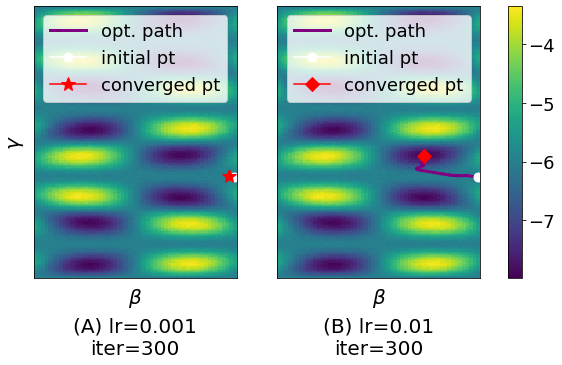

In [22]:
def diverge_due_to_bp():

    # derive origin full landscapes
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()

    # derive optimization paths
    opt_data1 = np.load(
        "figs/opt_on_origin_landscape/2022-10-10_22:44:02/use_case_data.npz",
        allow_pickle=True)

    opt_data2 = np.load(
        "figs/opt_on_origin_landscape/2022-10-10_22:42:34/use_case_data.npz",
        allow_pickle=True
    )

    params1 = opt_data1['params_path'].tolist()
    params2 = opt_data2['params_path']

    params1 = [[p[1], p[0]] for p in params1]
    params2 = [[p[1], p[0]] for p in params2]
        
    # params_paths = [opt_data1['params_path'].tolist(), opt_data1['params_path'].tolist(), opt_data2['params_path']]
    params_paths = [params1, params2]

    params = {'legend.fontsize': 18,
          'figure.figsize': (10, 5),
         'axes.labelsize': 20, #'x-large',
         'axes.titlesize': 20, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
    plt.rcParams.update(params)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    labels=["(A) lr=0.001\niter=300", "(B) lr=0.01\niter=300"]
    save_path="paper_figs/diverge_due_to_bp.pdf"
    # _vis_landscapes(
    #     fig,
    #     axs,
    #     landscapes=[origin['unmitis'].transpose(), recon['unmitis'].transpose(), origin['unmitis'].transpose()],
    #     labels=["(A) lr=0.001\niter=300", "(B) Recon.", "(C) lr=0.01\niter=300"],
    #     full_range=full_range,
    #     true_optima=None,
    #     title="Debug poor learning rate (lr) to escape barren plateaus",
    #     save_path="paper_figs/diverge_due_to_bp.pdf",
    #     params_paths=params_paths,
    #     converged_soln_markers=["*", "*", "D"]
    # )

    _vis_landscapes(
        fig,
        axs,
        landscapes=[-origin['unmitis'].transpose(), -origin['unmitis'].transpose()],
        labels=labels,
        full_range=full_range,
        true_optima=None,
        title="Debug poor learning rate (lr) to escape barren plateaus",
        save_path="paper_figs/diverge_due_to_bp.pdf",
        params_paths=params_paths,
        converged_soln_markers=["*", "D"]
    )

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.3)
    # axs[1].set_title(labels[1], y=-0.3)
    # if save_path != None:
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')
diverge_due_to_bp()

save to  paper_figs/diverge_not_due_to_bp.pdf


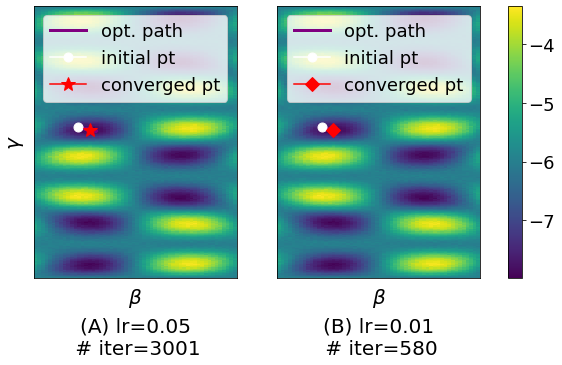

In [23]:
def diverge_not_due_to_bp():
    # derive origin full landscapes
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()

    # derive optimization paths
    opt_data1 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_00:15:41/use_case_data.npz",
        allow_pickle=True)

    opt_data2 = np.load(
        "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1/use_cases/2022-10-08_00:11:49/use_case_data.npz",
        allow_pickle=True
    )

    params1 = opt_data2['params_path'].tolist()
    params2 = opt_data1['params_path']

    # params_paths = [opt_data2['params_path'].tolist(), opt_data1['params_path']]
    params1 = [[p[1], p[0]] for p in params1]
    params2 = [[p[1], p[0]] for p in params2]

    params_paths = [params1, params2]
    # params_paths = [opt_data2['params_path'].tolist(), opt_data2['params_path'].tolist(), opt_data1['params_path']]

    # _vis_landscapes(
    #     landscapes=[origin['unmitis'], recon['unmitis'], origin['unmitis']],
    #     labels=["lr=0.05\n # iter=3001", "reconstructed", "lr=0.01\n # iter=580"],
    #     full_range=full_range,
    #     true_optima=None,
    #     title="Debug poor learning rate (lr) to reduce iterations",
    #     save_path="paper_figs/case2.png",
    #     params_paths=params_paths,
    #     converged_soln_markers=["*", "*", "D"]
    # )

    
    params = {'legend.fontsize': 18,
          'figure.figsize': (10, 5),
         'axes.labelsize': 20, #'x-large',
         'axes.titlesize': 20, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
    plt.rcParams.update(params)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    labels=["(A) lr=0.05\n # iter=3001", "(B) lr=0.01\n # iter=580"]
    save_path="paper_figs/diverge_not_due_to_bp.pdf"
    _vis_landscapes(
        fig,
        axs,
        landscapes=[-origin['unmitis'].transpose(), -origin['unmitis'].transpose()],
        labels=labels,
        full_range=full_range,
        true_optima=None,
        title="Debug poor learning rate (lr) to escape barren plateaus",
        save_path="paper_figs/diverge_due_to_bp.pdf",
        params_paths=params_paths,
        converged_soln_markers=["*", "D"]
    )
    
    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.3)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')


diverge_not_due_to_bp()

save to  paper_figs/compare_ADAM_and_SPSA.pdf


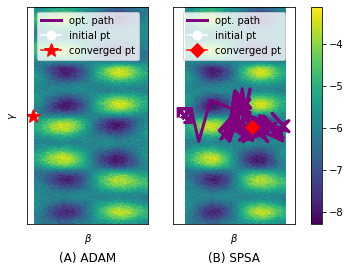

In [3]:
# n8, no use
def vis_choose_optimizer():

    # derive origin full landscape
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    params1 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:52:27/data.npz", allow_pickle=True)['params_path']
    params2 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:55:28/data.npz", allow_pickle=True)['params_path']

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()
    
    fig, axs = plt.subplots(nrows=1, ncols=2)
    save_path = "paper_figs/compare_ADAM_and_SPSA.pdf"
    labels=["(A) ADAM", "(B) SPSA"]
    _vis_landscapes(
        fig,
        axs,
        landscapes=[-recon["mitis"].transpose(), -recon["mitis"].transpose()],
        labels=labels,
        full_range=full_range,
        true_optima=None,
        title="Choose optimizers on reconstructed mitigated landscape",
        save_path=save_path,
        params_paths=[params1, params2],
        converged_soln_markers=["*", "D"]
    )

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.2)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')

vis_choose_optimizer()


read grid search data from figs/grid_search/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-RichardsonFactory.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-depolar-0.001-0.02-p=1/recon-cs_seed=16-sf=0.050-maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-50-100-zne-RichardsonFactory.npz
save to  paper_figs/compare_ADAM_and_COBYLA.pdf


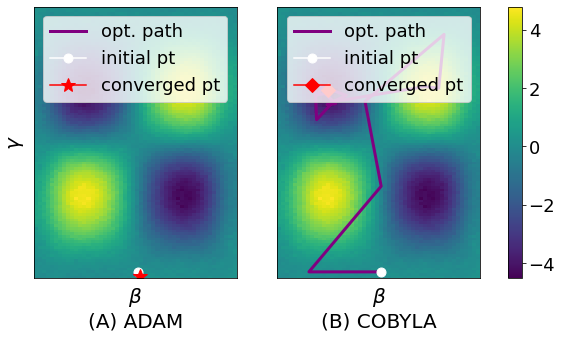

In [21]:
# n16
def vis_choose_optimizer(n, p, noise, seed, miti_method):
    problem = 'maxcut'
    method = 'sv'
    cs_seed = n
    maxiter = 1000

    sf = 0.05
    if p == 1:
        bs = 50
        gs = 100
    elif p == 2:
        bs = 12
        gs = 15
    else:
        raise NotImplementedError()

    data, data_fname, data_dir = load_grid_search_data(
        n_qubits=n, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method
    )

    recon_dir = f"figs/grid_search_recon/{problem}/{method}-{noise}-p={p}"
    plot_range = data['plot_range']

    recon_fname = f"recon-cs_seed={cs_seed}-sf={sf:.3f}-{data_fname}"
    recon_path = f"{recon_dir}/{recon_fname}"

    origin = data['data']
    recon = get_recon_landscape(p, origin, sf, False, recon_path, cs_seed)

    init_pt = [0.02, -1.51]

    # intp_path_path, _, _ = get_interpolation_path_filename(n, p, problem, method, noise, optimizer, maxiter, init_pt, seed, None)
    # print("intp path:", intp_path_path)
    # intp_path = np.load(intp_path_path, allow_pickle=True)['intp_path']

    adam_data = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-ADAM-maxiter=1000-[0.02, -1.51].npz"
        , allow_pickle=True
    )
    
    cobyla_data = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-depolar-0.001-0.02-p=1/maxcut-sv-depolar-0.001-0.02-n=16-p=1-seed=0-COBYLA-maxiter=1000-[0.02, -1.51].npz"
        , allow_pickle=True
    )
    
    # circ_path = np.load(
    #     "figs/optimization/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz"
    #     , allow_pickle=True
    # )['optimizer_path']
    # circ_path = load_optimization_path(n, p, problem, method, noise, optimizer, None, maxiter, init_pt, seed, None)

    params = {'legend.fontsize': 18,
            'figure.figsize': (10, 5),
            'axes.labelsize': 20, #'x-large',
            'axes.titlesize': 20, #'x-large',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18}
    plt.rcParams.update(params)
    
    fig, axs = plt.subplots(nrows=1, ncols=2)
    save_path = "paper_figs/compare_ADAM_and_COBYLA.pdf"
    labels=["(A) ADAM", "(B) COBYLA"]
    _vis_landscapes(
        fig,
        axs,
        landscapes=[recon, recon],
        labels=labels,
        full_range=plot_range,
        true_optima=None,
        title="Choose optimizers on reconstructed mitigated landscape",
        save_path=save_path,
        params_paths=[adam_data['intp_path'], cobyla_data['intp_path']],
        converged_soln_markers=["*", "D"]
    )

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.2)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')

vis_choose_optimizer(16, 1, "depolar-0.001-0.02", 0, "zne-RichardsonFactory")


read grid search data from figs/grid_search/maxcut/sv-ideal-p=1/sv-ideal-n=16-p=1-seed=0-50-100.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-ideal-p=1/recon-cs_seed=16-sf=0.050-sv-ideal-n=16-p=1-seed=0-50-100.npz
intp path: figs/opt_on_recon_landscape/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz
opt data load from figs/optimization/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz
save to  paper_figs/compare_intp_and_circ.pdf


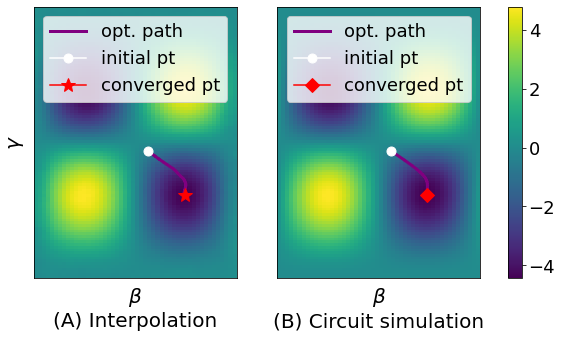

In [12]:
def vis_comp_intp_n16(n: int, p: int, seed: int, noise: str, optimizer: str, maxiter: int, miti_method: str):
    problem = 'maxcut'
    method = 'sv'
    cs_seed = n

    sf = 0.05
    if p == 1:
        bs = 50
        gs = 100
    elif p == 2:
        bs = 12
        gs = 15
    else:
        raise NotImplementedError()

    data, data_fname, data_dir = load_grid_search_data(
        n_qubits=n, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method
    )

    recon_dir = f"figs/grid_search_recon/{problem}/{method}-{noise}-p={p}"
    plot_range = data['plot_range']

    recon_fname = f"recon-cs_seed={cs_seed}-sf={sf:.3f}-{data_fname}"
    recon_path = f"{recon_dir}/{recon_fname}"

    origin = data['data']
    recon = get_recon_landscape(p, origin, sf, False, recon_path, cs_seed)

    init_pt = [0.1, -0.1]

    intp_path_path, _, _ = get_interpolation_path_filename(n, p, problem, method, noise, optimizer, maxiter, init_pt, seed, None)
    print("intp path:", intp_path_path)
    intp_path = np.load(intp_path_path, allow_pickle=True)['intp_path']

    # circ_path = np.load(
    #     "figs/optimization/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz"
    #     , allow_pickle=True
    # )['optimizer_path']
    circ_path = load_optimization_path(n, p, problem, method, noise, optimizer, None, maxiter, init_pt, seed, None)
    

    params = {'legend.fontsize': 18,
            'figure.figsize': (10, 5),
            'axes.labelsize': 20, #'x-large',
            'axes.titlesize': 20, #'x-large',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18}
    plt.rcParams.update(params)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    save_path = "paper_figs/compare_intp_and_circ.pdf"
    labels=["(A) Interpolation", "(B) Circuit simulation"]
    _vis_landscapes(
        fig,
        axs,
        landscapes=[recon, origin],
        labels=labels,
        full_range=plot_range,
        true_optima=None,
        title="Choose optimizers on reconstructed mitigated landscape",
        save_path=save_path,
        params_paths=[intp_path, circ_path],
        converged_soln_markers=["*", "D"]
    )

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.2)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')
vis_comp_intp_n16(16, 1, 0, "ideal", "ADAM", 10000, None)


read grid search data from figs/grid_search/maxcut/sv-ideal-p=1/sv-ideal-n=16-p=1-seed=0-50-100.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-ideal-p=1/recon-cs_seed=16-sf=0.050-sv-ideal-n=16-p=1-seed=0-50-100.npz
intp path: figs/opt_on_recon_landscape/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz
save to  paper_figs/cost_vals_and_opt_path.pdf


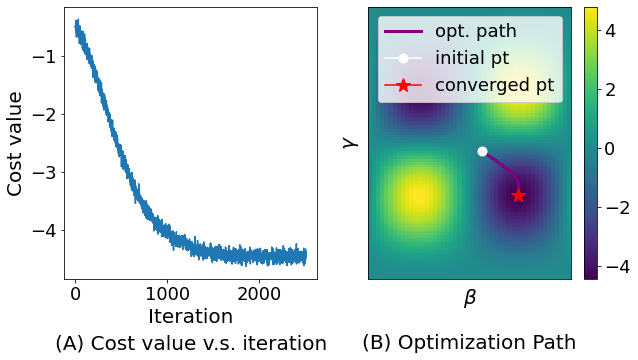

In [16]:
def sec3_vals_and_path(n: int, p: int, seed: int, noise: str, optimizer: str, maxiter: int, miti_method: str):
    problem = 'maxcut'
    method = 'sv'
    cs_seed = n

    sf = 0.05
    if p == 1:
        bs = 50
        gs = 100
    elif p == 2:
        bs = 12
        gs = 15
    else:
        raise NotImplementedError()

    data, data_fname, data_dir = load_grid_search_data(
        n_qubits=n, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method
    )

    recon_dir = f"figs/grid_search_recon/{problem}/{method}-{noise}-p={p}"
    plot_range = data['plot_range']

    recon_fname = f"recon-cs_seed={cs_seed}-sf={sf:.3f}-{data_fname}"
    recon_path = f"{recon_dir}/{recon_fname}"

    origin = data['data']
    recon = get_recon_landscape(p, origin, sf, False, recon_path, cs_seed)

    init_pt = [0.1, -0.1]

    intp_path_path, _, _ = get_interpolation_path_filename(n, p, problem, method, noise, optimizer, maxiter, init_pt, seed, None)
    print("intp path:", intp_path_path)
    intp_path = np.load(intp_path_path, allow_pickle=True)['intp_path']

    opt_data = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz"
        # "figs/optimization/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz"
        , allow_pickle=True
    )

    circ_path = opt_data['circ_path']
    circ_vals = opt_data['circ_vals']
    # circ_path = load_optimization_path(n, p, problem, method, noise, optimizer, None, maxiter, init_pt, seed, None)
    

    params = {'legend.fontsize': 18,
            'figure.figsize': (10, 5),
            'axes.labelsize': 20, #'x-large',
            'axes.titlesize': 20, #'x-large',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18}
    plt.rcParams.update(params)

    fig, axs = plt.subplots(nrows=1, ncols=2)
    save_path = "paper_figs/cost_vals_and_opt_path.pdf"
    labels=["(A) Cost value v.s. iteration", "(B) Optimization Path"]
    _vis_landscapes(
        fig,
        axs[1:],
        landscapes=[origin],
        labels=None,
        full_range=plot_range,
        true_optima=None,
        title=None,
        save_path=save_path,
        params_paths=[circ_path],
        converged_soln_markers=["*"]
    )

    axs[0].plot(range(len(circ_vals)), circ_vals)
    axs[0].set_ylabel("Cost value")
    axs[0].set_xlabel("Iteration")

    for idx in [0,1]:
        axs[idx].set_title(labels[idx], y=-0.28)
    print("save to ", save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')
sec3_vals_and_path(16, 1, 0, "ideal", "ADAM", 10000, None)

In [ ]:
# # n=16

# from data_loader import get_recon_landscape, get_recon_pathname, load_grid_search_data


# def sec3_path_and_landscape():
#     method = 'sv'
#     problem = 'maxcut'
#     n = 16 # ! largest noisy landscape
#     noise = 'depolar-0.001-0.02'
    
#     noise_model = None # TODO
#     # raise NotImplementedError()

#     # n_qubits = 16
#     cs_seed = n
#     p = 1
#     sf = 0.05
#     seed = 0
#     bs = 50
#     gs = 100

#     origin_data, data_fname, _ = load_grid_search_data(
#         n_qubits=n, p=p, problem=problem, method=method,
#         noise=noise, beta_step=bs, gamma_step=gs, seed=seed,
#     )

#     full_range = origin_data['full_range']
    
#     beta_bound = origin_data['beta_bound']
#     gamma_bound = origin_data['gamma_bound']

#     bounds = np.array([[-gamma_bound, gamma_bound], [-beta_bound, beta_bound]])
#     origin = origin_data['data']

#     # load recon data
#     recon_path, _, _ = get_recon_pathname(p, problem, method, noise, cs_seed, sf, data_fname)
#     recon = get_recon_landscape(p, origin, sf, False, recon_path, cs_seed)

#     # ---------------- load data complete ---------------
#     # G = nx.random_regular_graph(3, n, seed)
#     # maxcut = Maxcut(G)
#     # problem = maxcut.to_quadratic_program()
#     # C, offset = problem.to_ising()
 
#     opt_data = np.load(
#         "figs/opt_on_recon_landscape/maxcut/sv-ideal-p=1/maxcut-sv-ideal-n=16-p=1-seed=0-ADAM-maxiter=10000-[0.1, -0.1].npz"
#         , allow_pickle=True)

#     circ_path = opt_data['circ_path']

#     _vis_landscapes(
#         landscapes=[origin, recon],
#         labels=["Origin", "Recon"],
#         full_range=full_range,
#         true_optima=None,
#         title="debug barren plateaus",
#         # save_path="paper_figs/debug_bp.png",
#         save_path=None,
#         params_paths=[circ_path, params]
#     )
# ec3_path_and_landscape()

In [10]:
def vis_comp_optimizer():
    dists = np.load(
        "figs/opt_on_recon_landscape/maxcut/sv-ideal-p=1/opt_on_recon-n=16-seed=[0, 1, 2, 3, 4, 5, 6, 7]-opt=['ADAM', 'COBYLA'].npz"
        , allow_pickle=True
    )['dists']

    


In [24]:
from cs_opt_on_recon_ls import optimize_on_p1_reconstructed_landscape, path_dist
def batch_compare_path(n: int, seed_range: List[int], noise: str, opts: List[str]):
    p = 1
    if len(seed_range) == 1:
        seeds = list(range(seed_range[0]))
    elif len(seed_range) == 2:
        seeds = list(range(seed_range[0], seed_range[1]))
    else:
        raise NotImplementedError()

    initial_point = [0.1, -0.1]
    miti_method = None
    
    dists = []
    # for seed, opt in itertools.product(seeds, opts):
    fig = plt.figure()
    paths = []
    for seed in seeds:
        for opt in opts:
            print(f"{n=}, {seed=}, {opt=}")
            if opt == 'ADAM':
                maxiter = 10000
            elif opt == 'COBYLA':
                maxiter = 1000
            elif opt == 'SPSA':
                maxiter = 100
            else:
                raise ValueError()

            intp_last_pt, circ_last_pt, intp_path, circ_path = optimize_on_p1_reconstructed_landscape(
                n, p, seed, noise, miti_method,
                initial_point, opt, None, maxiter
            )

            common_len_dist = path_dist(intp_path, circ_path)
            # print(common_len_dist)

            l2_norm = np.linalg.norm(intp_last_pt - circ_last_pt)
            dists.append(l2_norm)

    # max_path_len = 0      
    # for path in paths:
    #     max_path_len = max(max_path_len, len(path))    
    # ADAM可以设个plt.ylim(0.01, 0.03)吗
    # if opt == 'ADAM':
    #     plt.ylim(0.0, 0.02)
    # elif opt == 'COBYLA':
    #     plt.ylim(0, 0.2)
    plt.plot(range(len(common_len_dist)), common_len_dist, label=f"{n=}, {seed=}, {opt}")
    plt.legend()
    fig.show()

opts = ["ADAM", "COBYLA", "SPSA"]
batch_compare_path(16, [1], "ideal", [opts[0]])

n=16, seed=0, opt='ADAM'

read grid search data from figs/grid_search/maxcut/sv-ideal-p=1/sv-ideal-n=16-p=1-seed=0-50-100.npz

tend to save to figs/grid_search_recon/maxcut/sv-ideal-p=1/recon-cs_seed=16-sf=0.050-sv-ideal-n=16-p=1-seed=0-50-100.npz
recon landscape read from figs/grid_search_recon/maxcut/sv-ideal-p=1/recon-cs_seed=16-sf=0.050-sv-ideal-n=16-p=1-seed=0-50-100.npz
bounds: [[-0.78539816  0.78539816]
 [-1.57079633  1.57079633]]
landscape shape: (50, 100)
optimizer:  ADAM
kwargs {'maxiter': 10000}
bound_lens [1.57079633 3.14159265]
grid_lens [0.03141593 0.03141593]
initial point: [0.1, -0.1]
res {   'fun': -4.456271498604004,
    'jac': None,
    'nfev': 801,
    'nit': None,
    'njev': None,
    'x': array([ 0.39217664, -0.61709676])}
None
opt_cut                     : 16.45611103011567
recon landscape minimum     : (-4.456271498604004+0j)
QAOA energy + offset        : (16.456271498604004-0j)
len of params: 2404


/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


ValueError: 

<Figure size 720x360 with 0 Axes>